In [25]:
import time
from IPython.display import display

notebook_start_time = time.perf_counter()
display("Notebook runtime: 0.00s", display_id="notebook_runtime")


'Notebook runtime: 2.51s'

<DisplayHandle display_id=notebook_runtime>

In [26]:
# Parameters
horizon_years = 12
steps_per_year = 12
n_paths = 25_000
seed_base = 42

V0 = 100.0
mu_base = 0.08
sigma_base = 0.18

r_grid_min = 0.02
r_grid_max = 0.16
r_grid_points = 40

r0 = 0.10
rate_shocks_bps = [200, 400]

cashflow_years = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
cashflow_amounts = [-20.0, -20.0, -20.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0]

save_summary_csv = True


# 20 Scenario and Discount-Rate Risk

This notebook combines two complementary views that often matter in private-market risk discussions:

1. **Scenario distributions for a long-horizon valuation index** (synthetic regimes for drift/volatility).
2. **Discount-rate sensitivity of a stylized J-curve cashflow** (NPV vs rate, rate shocks, and a tornado chart).

**Outputs**
- Figures are saved to `figures/20_scenario_and_discount_rate_risk/` with stable filenames.
- A terminal-metrics table is printed; optionally saved to `data/processed/scenario_terminal_summary.csv`.

**Reading guide**
- The GBM scenarios change the distribution of outcomes for `V_T` (dispersion / downside probability).
- The discount-rate analysis holds cashflows fixed and isolates present-value risk from the discount factor.

All results are synthetic and illustrative only (not a backtest, not investment advice).


In [27]:
import os
import sys

parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.gbm import simulate_gbm_paths
from src.cashflows import npv, npv_curve


In [29]:
figures_dir = os.path.join(parent_dir, "figures", "20_scenario_and_discount_rate_risk")
os.makedirs(figures_dir, exist_ok=True)

plt.style.use("seaborn-v0_8-whitegrid")
np.set_printoptions(precision=4, suppress=True)


## Context & assumptions

We use a simplified setup to keep the mechanics transparent:

- **Valuation proxy:** a single index-like level `V_t` simulated under GBM.
- **Horizon:** long (multi-year) to highlight compounding and tail effects.
- **Regimes:** a small set of labeled `(mu, sigma)` pairs to represent different environments.
- **Cashflows:** a toy J-curve schedule (contributions followed by distributions).
- **Discounting:** flat annual rate `r` with discount factors `(1 + r) ** t` where `t` is in years.

What this notebook is:
- A compact, deterministic template for scenario comparison and discount-rate sensitivity.

What it is not:
- A calibrated model, backtest, or a representation of any specific asset class index.


## Scenario definitions (regimes)

Each scenario is a labeled regime defined by:

- `mu`: an annualized drift parameter (a stylized long-run return assumption)
- `sigma`: an annualized volatility parameter (dispersion / uncertainty)

We keep the scenario count small so the resulting plots and tables stay readable. Seeds are fixed so the notebook is deterministic given the parameters.


**Modeling note (why GBM here)**

GBM is a deliberately simple long-horizon toy model: it preserves positivity and produces lognormal tails. It is useful for illustrating *how* scenario assumptions change distributions, but it omits features common in private markets (stale pricing, leverage, cashflow-dependent dynamics, illiquidity, regime switching, and fat-tailed shocks).


In [30]:
scenarios = [
    {"name": "Base", "mu": mu_base, "sigma": sigma_base, "color": "#1f77b4"},
    {"name": "Optimistic", "mu": 0.10, "sigma": 0.16, "color": "#2ca02c"},
    {"name": "Stagnation", "mu": 0.04, "sigma": 0.12, "color": "#ff7f0e"},
    {"name": "Crisis", "mu": -0.02, "sigma": 0.30, "color": "#d62728"},
]

n_steps = int(horizon_years * steps_per_year)
scenario_results = {}
scenario_bands = {}

percentiles = np.array([5, 25, 50, 75, 95])

for i, scenario in enumerate(scenarios):
    t_grid, paths = simulate_gbm_paths(
        S0=V0,
        mu=scenario["mu"],
        sigma=scenario["sigma"],
        T=horizon_years,
        n_steps=n_steps,
        n_paths=n_paths,
        seed=seed_base + i * 101,
    )
    scenario_results[scenario["name"]] = {
        "t_grid": t_grid,
        "paths": paths,
        "config": scenario,
    }
    scenario_bands[scenario["name"]] = np.percentile(paths, percentiles, axis=0)


## Long-horizon simulation + fan chart

We simulate paths under each regime and summarize the cross-sectional distribution over time.

How to read the fan chart:
- The shaded bands show percentile ranges (5-95 and 25-75).
- The median path is a robust central tendency (less sensitive than the mean).

The figure is saved with a stable filename so it can be referenced from notes or reports.


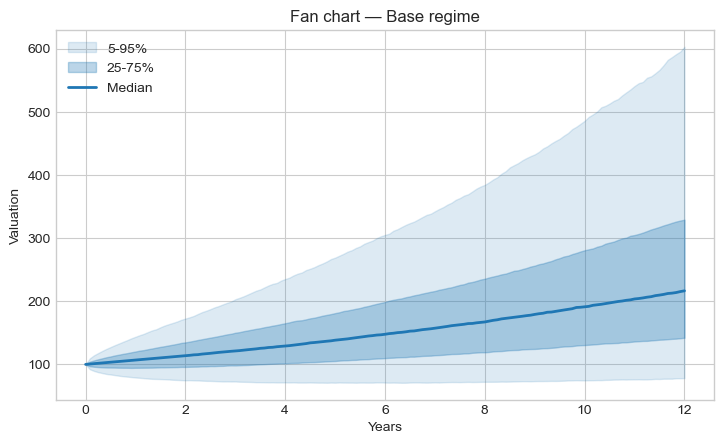

In [31]:
base_name = scenarios[0]["name"]
base_config = scenario_results[base_name]["config"]
t_grid = scenario_results[base_name]["t_grid"]
bands = scenario_bands[base_name]

fig, ax = plt.subplots(figsize=(8.5, 4.8))
ax.fill_between(t_grid, bands[0], bands[-1], color=base_config["color"], alpha=0.15, label="5-95%")
ax.fill_between(t_grid, bands[1], bands[3], color=base_config["color"], alpha=0.30, label="25-75%")
ax.plot(t_grid, bands[2], color=base_config["color"], linewidth=2.0, label="Median")
ax.set_title(f"Fan chart — {base_name} regime")
ax.set_xlabel("Years")
ax.set_ylabel("Valuation")
ax.legend(loc="upper left")

fan_path = os.path.join(figures_dir, "fan_chart_base.png")
fig.savefig(fan_path, dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)


## Downside-focused metrics at horizon

For each scenario we compute a small set of terminal statistics at the horizon:

- Mean / median / standard deviation of `V_T`
- A 5th percentile (a simple downside summary)
- `P(V_T < V0)` as an intuitive loss-probability proxy

We also overlay a few terminal histograms (kept intentionally uncluttered) to compare distribution shape and downside mass.


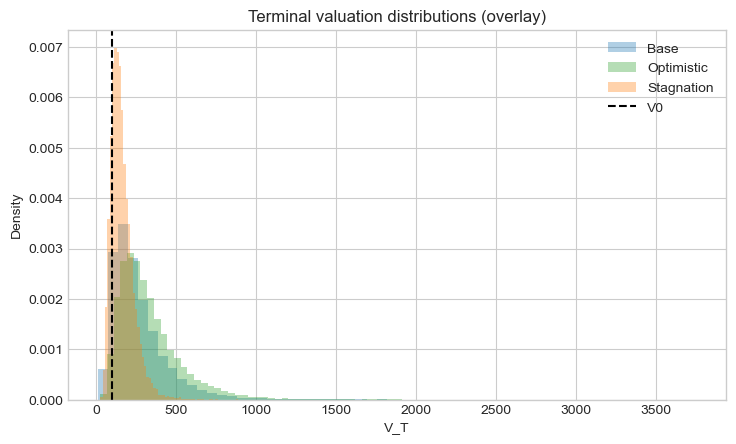

In [32]:
summary_rows = []
for scenario in scenarios:
    name = scenario["name"]
    paths = scenario_results[name]["paths"]
    terminal = paths[:, -1]
    summary_rows.append(
        {
            "Scenario": name,
            "Mean": terminal.mean(),
            "Median": np.median(terminal),
            "Std": terminal.std(ddof=1),
            "5%": np.quantile(terminal, 0.05),
            "P(V_T < V0)": np.mean(terminal < V0),
        }
    )

summary_df = pd.DataFrame(summary_rows).set_index("Scenario")
summary_df

if save_summary_csv:
    summary_path = os.path.join(parent_dir, "data", "processed", "scenario_terminal_summary.csv")
    os.makedirs(os.path.dirname(summary_path), exist_ok=True)
    summary_df.to_csv(summary_path)

fig, ax = plt.subplots(figsize=(8.5, 4.8))
for scenario in scenarios[:3]:
    name = scenario["name"]
    terminal = scenario_results[name]["paths"][:, -1]
    ax.hist(
        terminal,
        bins=60,
        density=True,
        alpha=0.35,
        label=name,
        color=scenario["color"],
    )

ax.axvline(V0, color="black", linestyle="--", linewidth=1.5, label="V0")
ax.set_title("Terminal valuation distributions (overlay)")
ax.set_xlabel("V_T")
ax.set_ylabel("Density")
ax.legend(loc="upper right")

terminal_path = os.path.join(figures_dir, "terminal_distribution_overlay.png")
fig.savefig(terminal_path, dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)


## Toy cashflow stream (J-curve) + NPV sensitivity

We define a stylized cashflow schedule:

- Years 1-3: negative cashflows (capital calls / contributions)
- Years 4-10: positive cashflows (distributions)

Sign convention:
- Negative = cash paid in.
- Positive = cash received.

We then compute NPV across a grid of discount rates to visualize how sensitive the present value is to the discount factor alone.


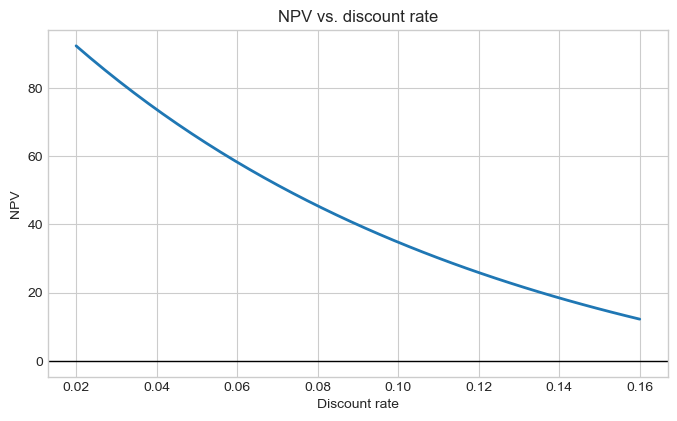

In [33]:
cashflows = np.array(cashflow_amounts, dtype=float)
times = np.array(cashflow_years, dtype=float)

rates = np.linspace(r_grid_min, r_grid_max, r_grid_points)
npv_grid = npv_curve(cashflows, times, rates)

fig, ax = plt.subplots(figsize=(8.0, 4.5))
ax.plot(rates, npv_grid, color="#1f77b4", linewidth=2.0)
ax.axhline(0.0, color="black", linewidth=1.0)
ax.set_title("NPV vs. discount rate")
ax.set_xlabel("Discount rate")
ax.set_ylabel("NPV")

npv_curve_path = os.path.join(figures_dir, "npv_vs_discount_rate.png")
fig.savefig(npv_curve_path, dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)


## Discount-rate stress (rate shocks)

A practical way to communicate discount-rate risk is to apply a small set of rate shocks.

- 200 bps = 2.00 percentage points
- 400 bps = 4.00 percentage points

We report the NPV change relative to a baseline `r0`. This isolates discount-rate sensitivity without changing the cashflow schedule.


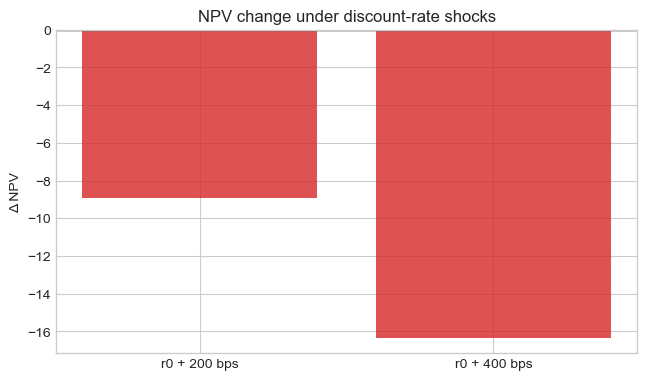

In [34]:
base_npv = npv(cashflows, times, r0)
stress_rates = [r0 + bps / 10_000 for bps in rate_shocks_bps]
stress_npvs = [npv(cashflows, times, rate) for rate in stress_rates]

labels = [f"r0 + {bps} bps" for bps in rate_shocks_bps]
delta_npvs = [value - base_npv for value in stress_npvs]

fig, ax = plt.subplots(figsize=(7.5, 4.2))
ax.bar(labels, delta_npvs, color="#d62728", alpha=0.8)
ax.axhline(0.0, color="black", linewidth=1.0)
ax.set_title("NPV change under discount-rate shocks")
ax.set_ylabel("Δ NPV")

shock_path = os.path.join(figures_dir, "npv_rate_shock_bars.png")
fig.savefig(shock_path, dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)


**Quick read:** If the schedule is net-positive in the future, NPV should generally *decrease* as rates rise. The bar chart makes that relationship concrete at a few stress points used in practice.


## Tornado chart: NPV sensitivity

A tornado chart ranks one-at-a-time shocks by their impact on NPV.

Included shocks (kept deliberately small and interpretable):
- Discount rate: `r0 +/- 200 bps`
- Exit proceeds scale: multiply positive cashflows by `(1 +/- 10%)`
- Timing: shift distribution years by `+/- 1` year (cash received later/earlier)

Interpretation tips:
- Bars to the left reduce NPV; bars to the right increase NPV.
- This is *not* a full sensitivity analysis: interactions and nonlinearities are ignored by design.


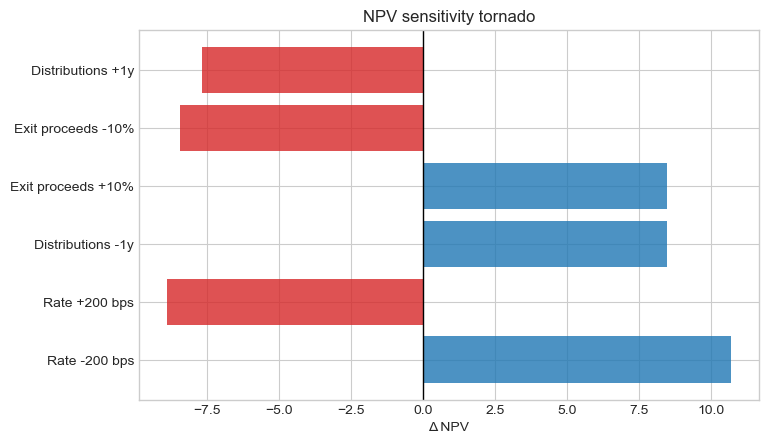

In [35]:
def shift_distribution_times(base_times, base_cashflows, shift_years):
    shifted = base_times.copy()
    mask = base_cashflows > 0.0
    shifted[mask] = np.maximum(0.0, shifted[mask] + shift_years)
    return shifted

base_npv = npv(cashflows, times, r0)

sensitivity_cases = []

# Discount rate shocks
sensitivity_cases.append(("Rate -200 bps", npv(cashflows, times, r0 - 0.02) - base_npv))
sensitivity_cases.append(("Rate +200 bps", npv(cashflows, times, r0 + 0.02) - base_npv))

# Exit proceeds scale
scale_up = cashflows.copy()
scale_up[scale_up > 0] *= 1.10
sensitivity_cases.append(("Exit proceeds +10%", npv(scale_up, times, r0) - base_npv))

scale_down = cashflows.copy()
scale_down[scale_down > 0] *= 0.90
sensitivity_cases.append(("Exit proceeds -10%", npv(scale_down, times, r0) - base_npv))

# Timing shift
times_late = shift_distribution_times(times, cashflows, shift_years=1.0)
sensitivity_cases.append(("Distributions +1y", npv(cashflows, times_late, r0) - base_npv))

times_early = shift_distribution_times(times, cashflows, shift_years=-1.0)
sensitivity_cases.append(("Distributions -1y", npv(cashflows, times_early, r0) - base_npv))

sensitivity_cases = sorted(sensitivity_cases, key=lambda x: abs(x[1]), reverse=True)
labels, deltas = zip(*sensitivity_cases)

fig, ax = plt.subplots(figsize=(8.0, 4.8))
colors = ["#1f77b4" if delta > 0 else "#d62728" for delta in deltas]
ax.barh(labels, deltas, color=colors, alpha=0.8)
ax.axvline(0.0, color="black", linewidth=1.0)
ax.set_title("NPV sensitivity tornado")
ax.set_xlabel("Δ NPV")

tornado_path = os.path.join(figures_dir, "npv_sensitivity_tornado.png")
fig.savefig(tornado_path, dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)


## Interpretation & limitations

Key takeaways:
- **Scenario dispersion compounds over long horizons**: even small differences in `mu`/`sigma` can produce materially different terminal distributions.
- **Discount rates can dominate PV outcomes**: for long-dated positive cashflows, rate changes often outweigh modest cashflow scaling assumptions.
- **Timing matters**: pushing distributions out (even by 1 year) can have a comparable impact to a sizable rate move.

Limitations:
- GBM is a simplified proxy and does not model regime switching, illiquidity, smoothed marks, or cashflow-contingent dynamics.
- The cashflow stream is stylized and not calibrated.
- Deterministic seeds make results reproducible, not realistic.


In [36]:
from IPython.display import update_display

elapsed = time.perf_counter() - notebook_start_time
update_display(f"Notebook runtime: {elapsed:.2f}s", display_id="notebook_runtime")
